In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing dataset

In [ ]:
ds=pd.read_csv('/content/SMSSpamCollection',sep='\t',header=None)
ds.columns=['Label','SMS']
print(ds.shape)
ds.head()
print(ds.SMS.head())

# Train test split

In [ ]:
randomized = ds.sample(frac=1,random_state=1)
train_size = round(len(randomized) * 0.8)
train = randomized[:train_size].reset_index(drop=True)
test = randomized[train_size:].reset_index(drop=True)
print(train.shape)
print(test.shape)

(4458, 2)
(1114, 2)


In [ ]:
train.SMS = train['SMS'].str.replace('\W',' ')
train.SMS = train['SMS'].str.lower()
train.SMS.head(10)

# creating vocab

In [ ]:
from itertools import chain
messages = train.SMS.str.split()
words = list(chain(*messages))
vocabulary = pd.Series(words).unique()

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1)

)
counts = vectorizer.fit_transform(train['SMS'])
print(len(vectorizer.get_feature_names()))

vocabulary = vectorizer.get_feature_names()

word_counts = dict(zip(vectorizer.get_feature_names(),np.transpose(counts.toarray())))


7477


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(-0.5, 1199.5, 799.5, -0.5)

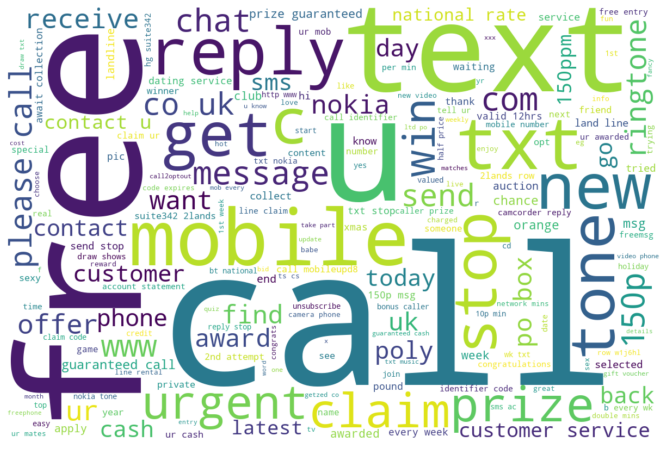

In [ ]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords
text = ""

for message in train[train.Label == 'spam'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "


wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

(-0.5, 1199.5, 799.5, -0.5)

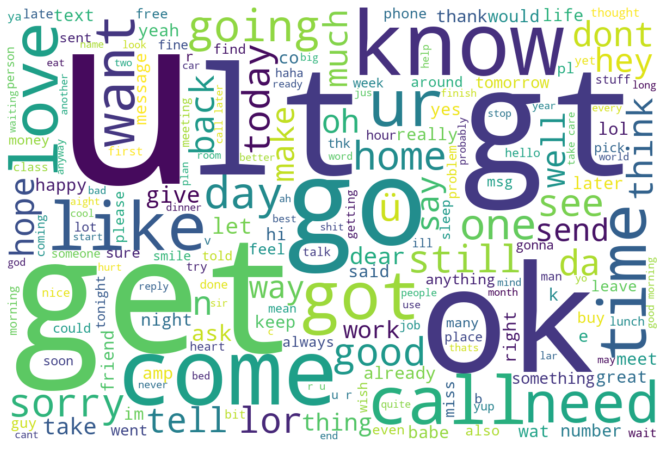

In [ ]:
from wordcloud import WordCloud
text = ""

for message in train[train.Label == 'ham'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "

# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# table with word counts

In [ ]:
x=pd.DataFrame(word_counts)
train=pd.concat([train,x],axis=1)
train.head(5)

,Label,SMS,00,000,000pes,008704050406,0089,01223585334,02,0207,...,zed,zeros,zhong,zindgi,zoe,zogtorius,zouk,zyada,ú1,〨ud
0,ham,yep by the pretty sculpture,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,yes princess are you going to make me moan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,welp apparently he retired,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,havent,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,i forgot 2 ask ü all smth there s a card on ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Implementation

* P_spam - probability of spam
* P_ham - probability of non-spam
* N_spam - number of words in spam messages
* N_ham - number of words in non-spam messages
* N_vocab - number of words in vocabulary
* Alpha - Laplace smoothing constant

In [ ]:
alpha = 1
P_spam = train.Label.value_counts(normalize=True)['spam']
P_ham = train.Label.value_counts(normalize=True)['ham']
N_spam = len(list(chain(*messages[train.Label == 'spam'])))
N_ham = len(list(chain(*messages[train.Label == 'ham'])))
N_vocab = len(vocabulary)



*   p(w|spam)
*   p(w|ham)



In [ ]:
P_word_given_spam = {word: 0 for word in vocabulary}
P_word_given_ham = {word: 0 for word in vocabulary}

Spam_messages = train[train.Label == 'spam']
Ham_messages = train[train.Label == 'ham']

for word in vocabulary:

    N_word_given_spam = Spam_messages[word].sum()
    N_word_given_ham = Ham_messages[word].sum()

    P_word_given_spam[word] = (
        (N_word_given_spam + alpha) / (N_spam + (alpha * N_vocab))
    )

    P_word_given_ham[word] = (
        (N_word_given_ham + alpha) / (N_ham + (alpha * N_vocab))
    )

Naive Bayes classifier:

In [ ]:
def classify(message):

    message = message.replace('\W',' ')
    message = message.lower()
    message = message.split()

    spam = 1
    ham = 1

    for word in message:
        if word in P_word_given_spam.keys():
            spam *= P_word_given_spam[word]
        if word in P_word_given_ham.keys():
            ham *= P_word_given_ham[word]

    P_spam_given_message = P_spam * spam
    P_ham_given_message = P_ham * ham



    if P_spam_given_message > P_ham_given_message:
        return 'spam'
    elif P_spam_given_message < P_ham_given_message:
        return 'ham'

In [ ]:
if(classify("How are you?")=='spam'):
  print('Spam')
else:
  print('ham')

ham


In [ ]:
test['predicted']=test.SMS.apply(classify)
#test[test.Label=='spam'].head(5)
test.head(10)

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham
5,ham,But my family not responding for anything. Now...,ham
6,ham,U too...,ham
7,ham,Boo what time u get out? U were supposed to ta...,ham
8,ham,Genius what's up. How your brother. Pls send h...,ham
9,ham,I liked the new mobile,spam


In [ ]:
accuracy = sum(test.Label == test.predicted)/len(test)
accuracy

0.9703770197486535